# Teaching a Deep-Q-Learning Agent to Play Tetris

This notebook provides you with a complete code example that trains a train a deep reinforcement learning model to play Tetris.

## Implementing a Simplified Tetris

In [1]:
import numpy as np
import random

class Tetris:
    """Simplified Tetris."""
        
    TILES = [
        [
            [[0, 2]],  # Tile 0, orientation 0.
            [[0, 1], [0, 1]],  # Tile 0, orientation 1.
        ],
        [
            [[1, 2], [0, 1]],  # Tile 1, orientation 0.
            [[0, 1], [1, 2]],  # Tile 1, orientation 1.
        ],
        [
            [[0, 2], [1, 2]],  # Tile 2, orientation 0.
            [[0, 2], [0, 1]],  # Tile 2, orientation 1.
            [[0, 1], [0, 2]],  # Tile 2, orientation 2.
            [[1, 2], [0, 2]],  # Tile 2, orientation 3.
        ],
        [
            [[0, 2], [0, 2]],  # Tile 3, orientation 0.
        ],
    ]
    
    UNDEFINED = -1

    def __init__(self, rows, cols, max_tiles, random_seed):
        """Initialize Tetris."""
        self.rows, self.cols = rows, cols
        self.max_tiles = max_tiles
        self.random_seed = random_seed
        
        self.restart()
        
    def restart(self):
        """Restart the game."""
        self.board = np.full((self.rows, self.cols), Tetris.UNDEFINED)
        self.current_tile = Tetris.UNDEFINED
        self.tile_x = Tetris.UNDEFINED
        self.tile_y = Tetris.UNDEFINED
        self.tile_orientation = Tetris.UNDEFINED

        self.gameover = False
        self.tile_count = 0

        # Create predefined tile sequence.
        rand_state = random.getstate()
        random.seed(self.random_seed)
        self.tile_sequence = [random.randint(0, len(Tetris.TILES) - 1) 
                              for _ in range(self.max_tiles)]
        random.setstate(rand_state)

        self.reward = 0
        
        self.next_tile()
        
    def next_tile(self):
        """Get the next tile."""
        if self.tile_count < self.max_tiles:
            if self.random_seed is not None:
                self.current_tile = self.tile_sequence[self.tile_count]
            else:
                self.current_tile = random.randint(0, len(Tetris.TILES) - 1)

            self.tile_x = self.cols // 2
            self.tile_y = self.rows
            self.tile_orientation = 0
            
            self.tile_count += 1
        else:
            self.gameover = True
    
    def move_left(self):
        """Move current tile to the left."""
        if self.tile_x - 1 >= 0:
            self.tile_x -= 1
            return True
        else:
            return False
    
    def move_right(self):
        """Move current tile to the right."""
        tile_width = len(Tetris.TILES[self.current_tile][self.tile_orientation])
        if self.tile_x + 1 <= self.cols - tile_width:
            self.tile_x += 1
            return True
        else:
            return False
    
    def rotate(self):
        """Rotate current tile."""
        new_orientation = ((self.tile_orientation + 1) 
                           % len(Tetris.TILES[self.current_tile]))
        tile_width = len(Tetris.TILES[self.current_tile][new_orientation])
        if self.tile_x <= self.cols - tile_width:
            self.tile_orientation = new_orientation
            return True
        else:
            return False
        
    def drop(self):
        """Drop current tile and update game board."""
        tile = Tetris.TILES[self.current_tile][self.tile_orientation]
        
        # Find first location where the tile collides with occupied locations.
        self.tile_y = 0
        for tile_column in range(len(tile)):
            # Tile final y position for this tile column 
            # if no other columns are taken into account.
            tile_y = -1
            for y in range(self.rows - 1, -1, -1):
                if self.board[y, self.tile_x + tile_column] > 0:
                    tile_y = y + 1 - tile[tile_column][0]
                    break
            # Update tile y position.
            if tile_y > self.tile_y:
                self.tile_y = tile_y

        if self.tile_y + np.max(tile) > self.rows:
            self.gameover = True
            dreward = -100
        else:
            # Change board entries at the newly placed tile to occupied.
            for tile_column in range(len(tile)):
                self.board[self.tile_y + tile[tile_column][0]
                        :self.tile_y + tile[tile_column][1], 
                        tile_column + self.tile_x] = 1

            # Remove full lines.
            removed_lines = 0
            for y in range(self.rows - 1, -1, -1):
                if np.sum(self.board[y, :]) == self.cols:
                    removed_lines += 1
                    for y1 in range(y, self.rows - 1):
                        self.board[y1, :] = self.board[y1 + 1, :]
                    self.board[self.rows - 1, :] = Tetris.UNDEFINED
            
            dreward = 10 ** (removed_lines - 1) if removed_lines > 0 else 0
        
        self.next_tile()
        self.reward += dreward
        return dreward

In [2]:
tetris = Tetris(rows=4, cols=4, max_tiles=50, random_seed=123456)

## Playing Tetris with the Command Line

## Playing Tetris with a Graphical Interface with Pygame

## Making an Agent Play Tetris with Q-Learning

### Adapting the Actions of Tetris for Q-Learning

Implement a class to play Tetris with Q-learning ...

In [3]:
class QLTetris(Tetris):
    """Simplified Tetris for Q-learning."""
    
    def __init__(self, rows, cols, max_tiles, random_seed):
        """Initialize Tetris for Q-learning."""
        super().__init__(rows, cols, max_tiles, random_seed)
    
    def teleport(self, new_x, new_orientation):
        """Teleport current tile to new position and orientation."""
        if 0 <= new_orientation < len(Tetris.TILES[self.current_tile]):
            tile_width = len(Tetris.TILES[self.current_tile][new_orientation])
            if 0 <= new_x <= self.cols - tile_width:
                self.tile_x = new_x
                self.tile_orientation = new_orientation
                return True
        return False

... and create an instance of this class.

In [4]:
qltetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=123456)

### Implementing the Q-Learning Agent

Implement a class representing a Q-learning agent ...

In [5]:
class QLAgent:
    """Q-learning agent to play Tetris."""
    
    def __init__(self, tetris, games, epsilon, alpha, gamma):
        """Initialize the agent."""
        self.tetris = tetris
        self.games, self.game = games, 0
        
        self.position_num = self.tetris.cols
        self.orientation_num = np.max([len(tile) for tile in Tetris.TILES])
        self.action_num = self.position_num * self.orientation_num
        
        self.state_size = (
            self.tetris.cols * self.tetris.rows  # Cells in board.
            + 1 + np.floor(np.log2(len(Tetris.TILES) - 1)).astype(int)  # Tiles.
        )
        self.state_num = 2 ** self.state_size

        self.epsilon = epsilon
        self.Q_table = np.zeros((self.state_num, self.action_num))
        
        self.alpha = alpha  # Learning rate.
        self.gamma = gamma  # Discount factor.
        self.rewards = np.zeros(games)
        
        self.update_state()

    def update_state(self):
        """Update the state of the agent."""
        tile = bin(self.tetris.current_tile)[2:]

        board = np.copy(self.tetris.board.reshape((-1,))).astype(int)
        board[board == Tetris.UNDEFINED] = 0
        
        self.state_binary = np.append(tile, board)
        self.state = int("".join(str(i) for i in self.state_binary), 2)

    def next_turn(self):
        """Executes the next turn in the game."""
        if self.tetris.gameover:
            self.rewards[self.game] = self.tetris.reward
            if self.game % 100 == 0:
                av_reward = np.mean(self.rewards[self.game - 100:self.game])
                print(f"game {self.game}/{self.games} reward {av_reward}")
                
            if self.game + 1 < self.games:
                self.game += 1
                self.tetris.restart()
                self.update_state()
            else:
                np.savetxt("Q_table.txt", self.Q_table)
                return False  # Finish.
        else:
            old_state = self.state
            
            if np.random.rand() < self.epsilon:
                action = np.random.randint(self.action_num)
            else:
                action = np.argmax(self.Q_table[self.state, :])
            
            new_x = action // self.position_num
            new_orientation = action % self.orientation_num

            if self.tetris.teleport(new_x, new_orientation):
                reward = self.tetris.drop()
                
                self.update_state()
                new_state = self.state
                
                dQ = self.alpha * (
                    reward
                    + self.gamma * np.max(self.Q_table[new_state, :])
                    - self.Q_table[old_state, action]
                )
                            
                self.Q_table[old_state, action] += dQ
            else:  # Penalty for illegal move.
                self.Q_table[old_state, action] += -50
            
        return True  # Continue.

... and a function to observe it play ...

... and observe the agent play.

### Training the Q-Learning Agent

Train the Q-learning agent ...

In [6]:
qltetris.restart()
agent = QLAgent(qltetris, games=1_000, epsilon=0, alpha=0.2, gamma=1)

while agent.next_turn():
    pass

game 0/1000 reward nan


/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


game 100/1000 reward -83.35
game 200/1000 reward -68.34
game 300/1000 reward -26.22
game 400/1000 reward 78.0
game 500/1000 reward 78.0
game 600/1000 reward 78.0
game 700/1000 reward 78.0
game 800/1000 reward 78.0
game 900/1000 reward 78.0


... plot the reward during training ...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


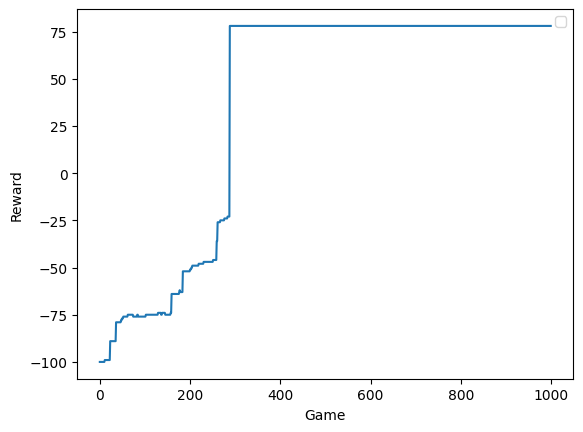

In [7]:
import matplotlib.pyplot as plt

plt.plot(agent.rewards)
plt.ylabel("Reward")
plt.xlabel("Game")
plt.legend()
plt.savefig("fig_13_03.pdf", bbox_inches="tight")  #plt.show()

... observe it play using the trained Q-table ...

... and analyze the sparsity of the trained Q-table.

### Training with a Random Tile Sequence

Train the Q-learning agent with a random tile sequence ...

In [8]:
qltetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=None)
agent = QLAgent(qltetris, games=200_000, epsilon=0.001, alpha=0.2, gamma=1)

while agent.next_turn():
    pass


/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


game 0/200000 reward nan
game 100/200000 reward -99.67
game 200/200000 reward -99.47
game 300/200000 reward -99.1
game 400/200000 reward -99.12
game 500/200000 reward -99.57
game 600/200000 reward -98.98
game 700/200000 reward -98.7
game 800/200000 reward -98.28
game 900/200000 reward -97.59
game 1000/200000 reward -98.17
game 1100/200000 reward -98.23
game 1200/200000 reward -97.97
game 1300/200000 reward -98.63
game 1400/200000 reward -97.71
game 1500/200000 reward -97.76
game 1600/200000 reward -97.37
game 1700/200000 reward -97.85
game 1800/200000 reward -97.9
game 1900/200000 reward -97.68
game 2000/200000 reward -97.23
game 2100/200000 reward -98.36
game 2200/200000 reward -98.11
game 2300/200000 reward -97.35
game 2400/200000 reward -97.67
game 2500/200000 reward -98.0
game 2600/200000 reward -97.39
game 2700/200000 reward -97.41
game 2800/200000 reward -97.22
game 2900/200000 reward -97.74
game 3000/200000 reward -97.68
game 3100/200000 reward -98.33
game 3200/200000 reward -97

... plot the reward during training ...

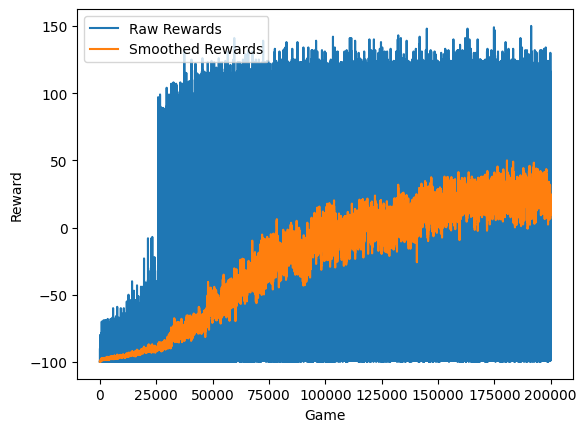

In [9]:
smoothed_rewards = np.convolve(agent.rewards, np.ones(100) / 100, mode="valid")

plt.plot(agent.rewards, label="Raw Rewards")
plt.plot(smoothed_rewards, label="Smoothed Rewards")
plt.ylabel("Reward")
plt.xlabel("Game")
plt.legend()
plt.savefig("fig_13_04.pdf", bbox_inches="tight")  # plt.show()


... and analyze the sparsity of the trained Q-table.

## Making an Agent Play Tetris with Deep Q-Learning

### Implementing the Deep-Q-Learning Agent

Add the neural networks to the QL agent ...

In [10]:
import deeplay as dl
import torch

class DQLAgent(dl.Application):
    """Deep-Q-learning agent to play Tetris."""
    
    def __init__(self, tetris, games, epsilon_max, epsilon_min, epsilon_scale,
                 alpha, gamma, hidden_units, replay_buffer_size, batch_size,
                 sync_target_game_count, **kwargs):
        """Initialize the agent."""
        self.tetris = tetris
        self.games, self.game = games, 0
        
        self.position_num = self.tetris.cols
        self.orientation_num = np.max([len(tile) for tile in Tetris.TILES])
        self.action_num = self.position_num * self.orientation_num

        self.state_size = (
            self.tetris.cols * self.tetris.rows  # Cells in board.
            + 1 + np.floor(np.log2(len(Tetris.TILES) - 1)).astype(int)  # Tiles.
        )
        self.state_num = 2 ** self.state_size

        self.epsilon_max = epsilon_max 
        self.epsilon_min = epsilon_min
        self.epsilon_scale = epsilon_scale
        self.epsilon = self.epsilon_max
        
        self.alpha = alpha  # Learning rate.
        self.gamma = gamma  # Discount factor.
        self.rewards = np.zeros(games)
        self.max_reward = 0

        self.q_net = self.get_net(hidden_units)
        self.target_net = self.get_net(hidden_units)

        super().__init__(
            loss=torch.nn.MSELoss(),
            optimizer=torch.optim.Adam(self.q_net.parameters(), lr=0.001),
            **kwargs,
        )

        self.buffer = []
        self.replay_buffer_size = replay_buffer_size
        self.batch_size = batch_size
        self.sync_target_game_count = sync_target_game_count
        
        self.update_state()

    def get_net(self, hidden_units):
        """Create instance of neural network."""
        net = dl.MultiLayerPerceptron(
            in_features=self.state_size,
            hidden_features=hidden_units,
            out_features=self.action_num,
        )
        return net.build()

    def update_state(self):
        """Update the state of the agent."""
        num_bits = int(np.ceil(np.log2(len(Tetris.TILES))))
        tile = bin(self.tetris.current_tile)[2:].zfill(num_bits)
        tile = np.array([int(i) for i in tile])

        board = np.copy(self.tetris.board.reshape((-1,))).astype(int)
        board[board == Tetris.UNDEFINED] = 0
        
        self.state_binary = np.append(tile, board)
        self.state = torch.tensor(self.state_binary, dtype=torch.float32)

    def next_turn(self):
        """Executes the next turn in the game."""
        if self.tetris.gameover:
            self.rewards[self.game] = self.tetris.reward
            if self.game % 100 == 0:
                av_reward = np.mean(self.rewards[self.game - 100:self.game])
                print(f"game {self.game}/{self.games} reward {av_reward}")
                if av_reward > self.max_reward:
                    self.max_reward = av_reward
                    torch.save(self.q_net.state_dict(), "q_net.pth")
                
            if self.game + 1 < self.games:
                self.game += 1
                if ((len(self.buffer) >= self.replay_buffer_size)
                    and (self.game % self.sync_target_game_count == 0)):
                    self.target_net.load_state_dict(self.q_net.state_dict())
                self.tetris.restart()
                self.update_state()
                
                self.epsilon = max(
                    self.epsilon_min,
                    self.epsilon_max - self.game / self.epsilon_scale,
                )
            else:
                return False  # Finish.
        else:
            old_state = self.state
            
            with torch.no_grad():
                if np.random.rand() < self.epsilon:
                    action = np.random.randint(self.action_num)
                else:
                    state = self.state.view(1, self.state_size)
                    output = self.q_net(state).detach().numpy()[0]
                    action = np.argmax(output)
                
                new_x = action // self.position_num
                new_orientation = action % self.orientation_num

                self.tetris.teleport(new_x, new_orientation)
                reward = self.tetris.drop()
                    
                self.update_state()
                new_state = self.state
                
                self.buffer.append({
                    "old_state": old_state, 
                    "action": action,
                    "reward": reward, 
                    "new_state": new_state,
                    "gameover": self.tetris.gameover,
                })
                if len(self.buffer) >= self.replay_buffer_size + 1:
                    self.buffer.pop(0)
            
            if len(self.buffer) >= self.replay_buffer_size:
                batch = random.sample(self.buffer, self.batch_size)

                # Store states in a list.
                states, next_states = [], []
                for sample in batch:
                    states.append(sample["old_state"])
                    next_states.append(sample["new_state"])
                
                # Initialize targets and target mask.
                targets = torch.zeros(self.batch_size, self.action_num)
                targets_mask = torch.zeros(self.batch_size, self.action_num)
                
                # Evaluate next state with TargetNet.
                with torch.no_grad():
                    q_hat = self.target_net(torch.stack(next_states, dim=0))
                
                # Compute targets.
                for idx, sample in enumerate(batch):
                    if sample["gameover"]:
                        target = sample["reward"]
                    else:
                        target = sample["reward"] + np.nanmax(q_hat[idx, :])
                    targets[idx, sample["action"]] = target
                    targets_mask[idx, sample["action"]] = 1
                
                # Evaluate preditions, apply mask, and update weights.
                self.optimizer.zero_grad()
                preds = self.q_net(torch.stack(states, dim=0))
                masked_preds = preds * targets_mask
                loss = self.loss(masked_preds, targets)
                loss.backward()
                self.optimizer.step()
            
        return True  # Continue.

... train the deep-Q-learning agent ...

In [11]:
qltetris = QLTetris(rows=4, cols=4, max_tiles=50, random_seed=None)
agent = DQLAgent(
    qltetris, games=10_000, epsilon_max=1, epsilon_min=0.001,
    epsilon_scale=5000, alpha=0.001, gamma=1, hidden_units=[128, 128],
    replay_buffer_size=10000, batch_size=64, sync_target_game_count=100,
)

while agent.next_turn():
    pass

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


game 0/10000 reward nan
game 100/10000 reward -99.66
game 200/10000 reward -99.66
game 300/10000 reward -99.67
game 400/10000 reward -99.68
game 500/10000 reward -99.55
game 600/10000 reward -99.63
game 700/10000 reward -99.62
game 800/10000 reward -99.69
game 900/10000 reward -99.71
game 1000/10000 reward -99.79
game 1100/10000 reward -99.65
game 1200/10000 reward -99.76
game 1300/10000 reward -99.61
game 1400/10000 reward -99.58
game 1500/10000 reward -99.8
game 1600/10000 reward -99.83
game 1700/10000 reward -99.75
game 1800/10000 reward -99.85
game 1900/10000 reward -99.82
game 2000/10000 reward -99.67
game 2100/10000 reward -99.63
game 2200/10000 reward -99.93
game 2300/10000 reward -99.78
game 2400/10000 reward -99.81
game 2500/10000 reward -99.81
game 2600/10000 reward -99.93
game 2700/10000 reward -99.77
game 2800/10000 reward -99.81
game 2900/10000 reward -98.72
game 3000/10000 reward -98.14
game 3100/10000 reward -98.01
game 3200/10000 reward -97.81
game 3300/10000 reward -97

... plot the reward during training ...

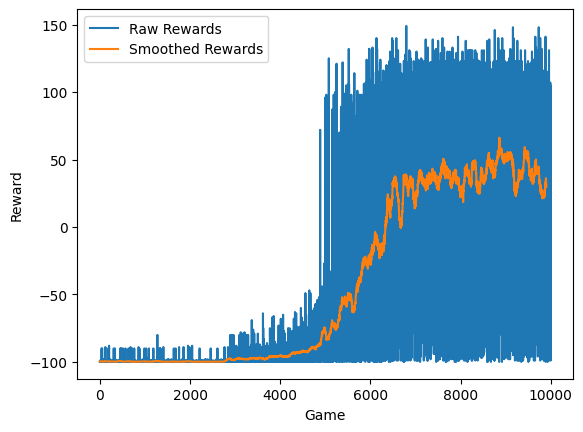

In [12]:
smoothed_rewards = np.convolve(agent.rewards, np.ones(100) / 100, mode="valid")

plt.plot(agent.rewards, label="Raw Rewards")
plt.plot(smoothed_rewards, label="Smoothed Rewards")
plt.ylabel("Reward")
plt.xlabel("Game")
plt.legend()
plt.savefig("fig_13_05.pdf", bbox_inches="tight")  # plt.show()

... and observe its behavior.